<a href="https://colab.research.google.com/github/Kidaha12/Project_4/blob/main/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clone the github repository to the google colab

!git clone https://github.com/Kidaha12/Project_4.git

fatal: destination path 'Project_4' already exists and is not an empty directory.


In [ ]:
# Imports

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import files
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random

In [ ]:
# Load the labels.csv file and encode it numerically for the model

labels_df = pd.read_csv('/content/Project_4/labels.csv')

label_encoder = LabelEncoder()

labels_df['encoded_breed'] = label_encoder.fit_transform(labels_df['breed'])

labels_df.head(10)

,id,breed,encoded_breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,10
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,10
7,002a283a315af96eaea0e28e7163b21b,borzoi,18
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,7
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,97


In [ ]:
# Defining several variables for future use

train_folder = "/content/Project_4/train"
train_names = labels_df['id'].tolist()
train_labels = labels_df['encoded_breed'].tolist()
test_folder = "/content/Project_4/test"
batch_size = 32
num_repeats = 11

In [ ]:
# Image generator function (10,000 training images took up too much memory to preproceses all at once)

def image_generator(image_folder, img_names, labels, batch_size, num_repeats):
    for _ in range(num_repeats):                                                   # num_repeats required so that the data loops for each
        start_idx = 0                                                              # epoch of training
        while start_idx < len(img_names):
            batch_img_names = img_names[start_idx:start_idx+batch_size]
            batch_labels = labels[start_idx:start_idx+batch_size]
            images = []
            for img_name in batch_img_names:
                img_path = os.path.join(image_folder, img_name + ".jpg")
                if os.path.exists(img_path):
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        images.append(img)
                    else:
                        print(f"Error loading image: {img_path}")
                else:
                    print(f"Image file not found: {img_path}")

            resized_images = [cv2.resize(img, (224, 224)) for img in images]
            normalized_images = np.array(resized_images) / 255.0

            yield normalized_images, np.array(batch_labels)                       # yield pauses the function instead of ending it so
                                                                                  # that the function can iterate through the data
            start_idx += batch_size

In [ ]:
# Define the model
model = models.Sequential()

# Add the layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))  # Used .nunique() to find the number of unique breeds

# Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          15,480 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,184,440 (42.67 MB)

 Trainable params: 11,184,440 (42.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the number of training steps per epoch based on the batch size and dataset size
train_steps_per_epoch = len(train_names) // batch_size      # Floor division to get an integer number of batches per epoch

# Create a data generator for the training dataset
train_generator = image_generator(train_folder, train_names, train_labels, batch_size=batch_size, num_repeats=num_repeats)

# Train the model for 10 epochs
model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          epochs=10)

Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1089s 3s/step - accuracy: 0.0080 - loss: 4.8268
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1077s 3s/step - accuracy: 0.0180 - loss: 4.7463
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1058s 3s/step - accuracy: 0.0675 - loss: 4.3194
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1046s 3s/step - accuracy: 0.2829 - loss: 3.1230
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1047s 3s/step - accuracy: 0.5216 - loss: 2.0470
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1049s 3s/step - accuracy: 0.6920 - loss: 1.2947
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1046s 3s/step - accuracy: 0.8090 - loss: 0.8615
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1045s 3s/step - accuracy: 0.8572 - loss: 0.6166
Epoch 9/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1068s 3s/step - accuracy: 0.9042 - loss: 0.4192
Epoch 10/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 1088s 3s/step - accuracy: 0.9306 - loss: 0.3002


In [ ]:
# Save the model
model.save('/content/Project_4/dog_breed_identification_9306.h5')


In [ ]:
# Download the model
files.download('/content/Project_4/dog_breed_identification_9306.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Upload the model for a new session
uploaded = files.upload()

# Load the model
model = load_model('/content/dog_breed_identification_9306.h5')

Saving dog_breed_identification_9306.h5 to dog_breed_identification_9306.h5


In [ ]:
# A different generator for debugging purposes

def train_image_generator(image_folder, img_names, batch_size):
    num_images = len(img_names)
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch_img_names = img_names[start_idx:end_idx]
        images = []
        for img_name in batch_img_names:
            img_path = os.path.join(image_folder, img_name + ".jpg")
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                else:
                    print(f"Error loading image: {img_path}")
            else:
                print(f"Image file not found: {img_path}")

        normalized_images = np.array(images) / 255.0
        yield (normalized_images,)  # Yield as a tuple with only inputs


In [ ]:
# Prepare the test image names
train_image_names = [f.split('.')[0] for f in os.listdir(train_folder) if f.endswith('.jpg')]

# Create a test data generator
train_generator = train_image_generator(train_folder, train_image_names, batch_size=batch_size)

# Calculate the number of steps
steps = (len(train_image_names) + batch_size - 1) // batch_size

# Make predictions
predictions = model.predict(train_generator, steps=steps)


320/320 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step


In [ ]:
# Find the highest probability breed (encoded)
predicted_labels = np.argmax(predictions, axis=1)

# Decode the numerical breed back into the corresponding string
predicted_breeds = label_encoder.inverse_transform(predicted_labels)


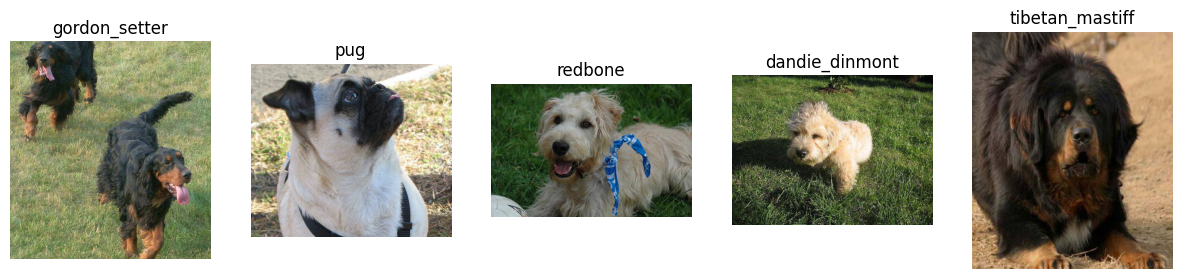

In [ ]:
# A function to display 5 random images from the "test" set along with the
# corresponding predictions

def display_predictions(image_folder, img_names, predictions, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(img_names))):
        img_path = os.path.join(image_folder, img_names[i] + ".jpg")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(predictions[i])
        plt.axis('off')
    plt.show()

# Select 5 random images
num_random_images = 5
random_indices = random.sample(range(len(train_image_names)), num_random_images)

# Create lists of random test image names and their predictions
random_train_image_names = [train_image_names[i] for i in random_indices]
random_predictions = [predicted_breeds[i] for i in random_indices]

# Display 5 random predictions
display_predictions(train_folder, random_train_image_names, random_predictions, num_images=num_random_images)
